In [1]:
import json
from influxdb import InfluxDBClient
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("../../../../secrets/homevision.json") as handler:
    creds = json.load(handler)

In [3]:
idb = InfluxDBClient(**creds)
idb.ping()

'1.8.1'

In [4]:
def get_points(connection, query, database):
    result = connection.query(query, database=database)
    frame = pd.DataFrame(result.get_points())
    frame["time"] = pd.to_datetime(frame["time"])
    return frame

### SDC30

In [5]:
co2 = get_points(idb, "SELECT * FROM scd30 WHERE time >= '2021-09-24 09:00:00' AND time <= '2021-09-24 17:00:00';", "homevision")
co2

,time,CO2,RH,T,device,location,owner
0,2021-09-24 09:00:08.613586+00:00,407.422638,55.996071,23.674484,bluebox-01,home-lab,jlandercy
1,2021-09-24 09:00:25.816873+00:00,407.228943,55.859966,23.703857,bluebox-01,home-lab,jlandercy
2,2021-09-24 09:00:41.125671+00:00,407.699554,55.784100,23.717209,bluebox-01,home-lab,jlandercy
3,2021-09-24 09:00:57.852246+00:00,407.482971,55.882935,23.690506,bluebox-01,home-lab,jlandercy
4,2021-09-24 09:01:14.014555+00:00,408.253479,55.938141,23.690506,bluebox-01,home-lab,jlandercy
...,...,...,...,...,...,...,...
1748,2021-09-24 16:58:42.865068+00:00,650.079468,52.162918,25.183220,bluebox-01,home-lab,jlandercy
1749,2021-09-24 16:58:59.055504+00:00,639.688721,51.632160,25.239296,bluebox-01,home-lab,jlandercy
1750,2021-09-24 16:59:15.118600+00:00,626.633789,51.373512,25.268677,bluebox-01,home-lab,jlandercy
1751,2021-09-24 16:59:31.506066+00:00,614.304993,51.476536,25.268677,bluebox-01,home-lab,jlandercy


In [6]:
p = get_points(idb, "SELECT * FROM bme280 WHERE time >= '2021-09-24 09:00:00' AND time <= '2021-09-24 17:00:00';", "homevision")
p = p.pivot_table(index="time", columns="location", values=["pressure", "humidity", "temperature"])
p.columns = ["RH (%)", "p (hPa)", "T' (°C)"]
p = p.resample("15S").mean().interpolate()
p

,RH (%),p (hPa),T' (°C)
time,,,
2021-09-24 09:00:00+00:00,35.211732,1014.605528,30.379784
2021-09-24 09:00:15+00:00,35.199898,1014.571180,30.387350
2021-09-24 09:00:30+00:00,35.170607,1014.562021,30.385459
2021-09-24 09:00:45+00:00,35.197105,1014.572203,30.377577
2021-09-24 09:01:00+00:00,35.205833,1014.565743,30.382306
...,...,...,...
2021-09-24 16:58:45+00:00,32.465794,1012.760200,31.989217
2021-09-24 16:59:00+00:00,32.255000,1012.746591,32.070557
2021-09-24 16:59:15+00:00,32.219236,1012.757775,32.090261


In [7]:
data = co2.set_index("time")[["CO2", "T"]]
data.columns = ["CO2 (ppm)", "T (°C)"]
data

,CO2 (ppm),T (°C)
time,,
2021-09-24 09:00:08.613586+00:00,407.422638,23.674484
2021-09-24 09:00:25.816873+00:00,407.228943,23.703857
2021-09-24 09:00:41.125671+00:00,407.699554,23.717209
2021-09-24 09:00:57.852246+00:00,407.482971,23.690506
2021-09-24 09:01:14.014555+00:00,408.253479,23.690506
...,...,...
2021-09-24 16:58:42.865068+00:00,650.079468,25.183220
2021-09-24 16:58:59.055504+00:00,639.688721,25.239296
2021-09-24 16:59:15.118600+00:00,626.633789,25.268677


<AxesSubplot:xlabel='time'>

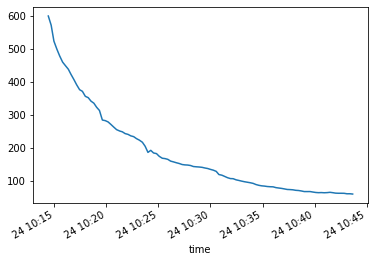

In [8]:
data.loc["2021-09-24 10:14:20":"2021-09-24 10:43:50", "CO2 (ppm)"].plot()

In [9]:
data["T (K)"] = data["T (°C)"] + 273.16
T0 = data["T (K)"].mean()
p0 = p["p (hPa)"].mean()/1e3
T0, p0

(297.45338165996964, 1.0134763790651724)

In [10]:
f = 2.46e13 # ppm -> molec/cm3

In [11]:
data["t (s)"] = data.index.map(lambda x: x.timestamp())

In [12]:
kinetic = data.loc["2021-09-24 10:15":"2021-09-24 10:40:00", ["CO2 (ppm)", "t (s)", "T (°C)", "T (K)"]]

In [13]:
kinetic["Ng (molec/cm³)"] = (kinetic["CO2 (ppm)"]*f)
kinetic["pNg (-)"] = kinetic["Ng (molec/cm³)"].apply(np.log10)

In [14]:
rho = 1                 # kg/L
kH = 0.035*rho          # mol/L*bar
NA = 6.022e23           # molec/mol
B0 = 2.5                # mol/L
S = (2.5)**2            # cm2
D = 1.61e-5             # cm2/s
k = 6.79e-10*NA*1e-3    # L/mol.s

In [15]:
kinetic = kinetic.resample("15S").mean().interpolate()

In [16]:
kinetic["t (s)"] -= kinetic["t (s)"].values[0]

In [17]:
kinetic = kinetic.merge(p, left_index=True, right_index=True)

In [18]:
kinetic["pCO2 (Bar)"] = p0*(kinetic["CO2 (ppm)"]/1e6)

In [19]:
kinetic

,CO2 (ppm),t (s),T (°C),T (K),Ng (molec/cm³),pNg (-),RH (%),p (hPa),T' (°C),pCO2 (Bar)
time,,,,,,,,,,
2021-09-24 10:15:15+00:00,500.383118,0.000000,25.199242,298.359242,1.230942e+16,16.090238,38.167342,1014.557284,32.016488,0.000507
2021-09-24 10:15:30+00:00,479.904785,15.976720,25.169868,298.329868,1.180566e+16,16.072090,38.505350,1014.564717,32.023897,0.000486
2021-09-24 10:15:45+00:00,460.835602,33.172112,25.212593,298.372593,1.133656e+16,16.054481,38.849241,1014.580293,32.027050,0.000467
2021-09-24 10:16:00+00:00,449.847809,49.710267,25.212593,298.372593,1.106626e+16,16.044001,39.146070,1014.571523,32.031463,0.000456
2021-09-24 10:16:15+00:00,439.248077,66.065390,25.199242,298.359242,1.080550e+16,16.033645,39.457517,1014.557394,32.046281,0.000445
...,...,...,...,...,...,...,...,...,...,...
2021-09-24 10:38:45+00:00,67.818455,1416.973560,25.601128,298.761128,1.668334e+15,15.222247,46.002472,1014.353611,32.423659,0.000069
2021-09-24 10:39:00+00:00,66.949341,1424.854698,25.607803,298.767803,1.646954e+15,15.216681,46.020088,1014.394303,32.423817,0.000068
2021-09-24 10:39:15+00:00,66.933250,1441.350796,25.594452,298.754452,1.646558e+15,15.216577,46.043561,1014.367424,32.422398,0.000068


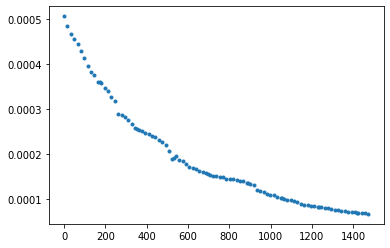

In [20]:
fig, axe = plt.subplots()
axe.plot(kinetic["t (s)"], kinetic["pCO2 (Bar)"], ".")

In [21]:
res = linregress(kinetic["t (s)"], np.log(kinetic["pCO2 (Bar)"]))

In [22]:
res

LinregressResult(slope=-0.0013493913433796861, intercept=-7.745757071198734, rvalue=-0.9944187569183174, pvalue=1.4701433485968791e-96, stderr=1.4536384069672292e-05)

In [23]:
def f(t, res):
    return np.exp(res.intercept + res.slope*t)

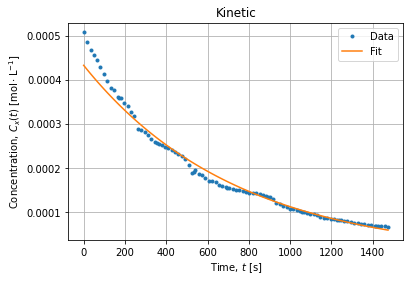

In [24]:
t = kinetic["t (s)"]
fig, axe = plt.subplots()
axe.plot(t, kinetic["pCO2 (Bar)"], ".", label="Data")
axe.plot(t, f(t, res), label="Fit")
axe.grid(which="both")
axe.set_title("Kinetic")
axe.set_xlabel(r"Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Concentration, $C_x(t)$ $[\mathrm{mol\cdot L^{-1}}]$")
axe.legend()

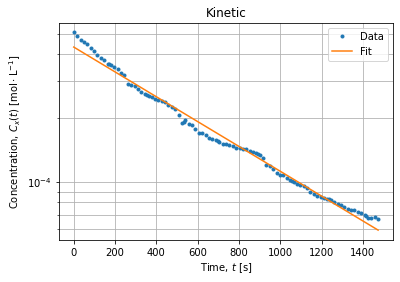

In [25]:
t = kinetic["t (s)"]
fig, axe = plt.subplots()
axe.semilogy(t, kinetic["pCO2 (Bar)"], ".", label="Data")
axe.semilogy(t, f(t, res), label="Fit")
axe.grid(which="both")
axe.set_title("Kinetic")
axe.set_xlabel(r"Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Concentration, $C_x(t)$ $[\mathrm{mol\cdot L^{-1}}]$")
axe.legend()

In [26]:
ks = -res.slope

In [27]:
k = ks/(p0*kH*B0*1e-6)
k

15216.551339001653

<AxesSubplot:xlabel='time'>

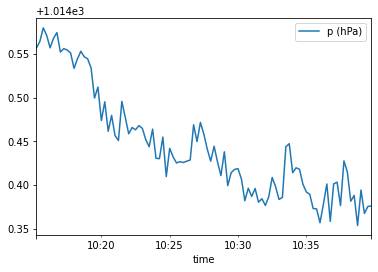

In [28]:
kinetic.filter(regex="p \(hPa\)").plot()

<AxesSubplot:xlabel='time'>

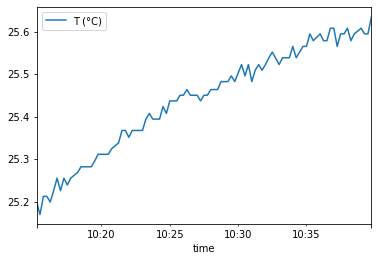

In [29]:
kinetic.filter(regex="T \(.C\)").plot()

<AxesSubplot:ylabel='Density'>

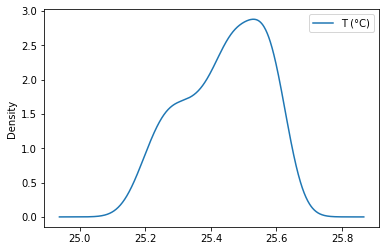

In [30]:
kinetic.filter(regex="T \(.C\)").plot(kind="kde")